In [11]:
"""
Neuron-level XAI for AD continuum prediction
"""

import torch
from PIL import Image
from torch.utils.data import Dataset, ConcatDataset
import torchvision.datasets as datasets
import os
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader , ConcatDataset
from torchvision import transforms
import torch.optim as optim
import torchvision.models as models
import torch.nn as nn
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import cluster
import umap
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
import seaborn as sns
import pickle
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from scipy.spatial import distance_matrix
import plotly.express as px
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
from matplotlib.pyplot import cm
import matplotlib as mpl
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
from matplotlib.ticker import StrMethodFormatter
import argparse
import sys
sys.path.append('./')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"




def computeAUC(dataGT, dataPRED):
    outAUROC = []
    datanpGT = dataGT.cpu().numpy()
    datanpPRED = dataPRED.cpu().numpy()
    return(roc_auc_score(datanpGT, datanpPRED))
    

def classreport(dataGT, predCLASS):
    datanpGT = dataGT.cpu().numpy()
    datanppredCLASS = predCLASS.cpu().numpy()
    return(classification_report(datanpGT, datanppredCLASS, digits = 3))

    
def computeACC(dataGT, dataCLASS):
    datanpGT = dataGT.cpu().numpy()
    datanpCLASS = dataCLASS.cpu().numpy()
    return(accuracy_score(datanpGT, datanpCLASS))
    


def top_neuron_extract(model_dir, test_img_dir, out_dir, layers, n_features_to_select=20, step=1000):
    '''extract k-top neurons from each layer'''
    activation = {}
    all_activation = {}
    outs = []
    act_list=[]
    all_activation_1, all_activation_2, all_activation_3, all_activation_4,all_activation_5,all_activation_6 ,all_activation_7,all_activation_8,all_activation_9,all_activation_10,all_activation_11,all_activation_12,all_activation_13,all_activation_14,all_activation_15=[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
    y_outputs = []
    y_class_predictions = []
    y_labels = []


    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])


    test_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        normalize,
    ])

    # load data
    test_fold = datasets.ImageFolder(test_img_dir, transform = test_transform)
    test_dataloader = DataLoader(test_fold, batch_size = 1, shuffle = False)

    # load model
    model = models.vgg16(pretrained=True)
    model.classifier[6] = nn.Linear(in_features=4096, out_features= 2, bias=True)
    checkpoint = torch.load(model_dir, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    model.to(device)

    def getActivation(name):
      # the hook signature
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # register forward hooks on the layers of choice
    h1 = model.features[4].register_forward_hook(getActivation('MaxPool_4'))
    h2 = model.features[9].register_forward_hook(getActivation('MaxPool_9'))
    h3 = model.features[16].register_forward_hook(getActivation('MaxPool_16'))
    h4 = model.features[23].register_forward_hook(getActivation('MaxPool_23'))
    h5 = model.features[30].register_forward_hook(getActivation('MaxPool_30'))
    h6 = model.classifier[0].register_forward_hook(getActivation('fc_0'))
    h7 = model.classifier[3].register_forward_hook(getActivation('fc_3'))

    # extract activation of neurons during evaluation of the images by the model
    outGT = torch.FloatTensor().to(device)
    outPRED = torch.FloatTensor().to(device)
    outClass = torch.FloatTensor().to(device)
    with torch.no_grad():
        for i, data in enumerate(test_dataloader):
            images, labels, = data
            images = images.float().to(device)
            labels = labels.float().to(device)
            output = model(images)
            # append all activations for each sample input
            all_activation_1.append(activation['MaxPool_4'].cpu().detach())
            all_activation_2.append(activation['MaxPool_9'].cpu().detach())
            all_activation_3.append(activation['MaxPool_16'].cpu().detach())
            all_activation_4.append(activation['MaxPool_23'].cpu().detach())
            all_activation_5.append(activation['MaxPool_30'].cpu().detach())
            all_activation_6.append(activation['fc_0'].cpu().detach())
            all_activation_7.append(activation['fc_3'].cpu().detach())
            outGT = torch.cat((outGT, labels), 0)
            softmax_preds = F.softmax(output, dim = 1)
            outPRED = torch.cat((outPRED, softmax_preds), 0)
            class_predictions = torch.argmax(softmax_preds, dim = 1)
            outClass = torch.cat((outClass, class_predictions), 0)

    # report performance of the model on test set
    with open(out_dir+"/output.txt","a") as file1:
        file1.write(str(classreport(outGT, outClass)))
        

    

    # detach the hooks
    h1.remove()
    h2.remove()
    h3.remove()
    h4.remove()
    h5.remove()
    h6.remove()
    h7.remove()




    # reduce dimensionality of activation maps from optinal choice of intermediate layers
    all_activation={'MaxPool_4':all_activation_1,'MaxPool_9':all_activation_2,'MaxPool_16':all_activation_3,'MaxPool_23':all_activation_4
                   ,'MaxPool_30':all_activation_5,'fc_0':all_activation_6,'fc_3':all_activation_7}
    act_1,act_2,act_3,act_4,act_5,act_6,act_7=[],[],[],[],[],[],[]=[],[],[],[],[],[],[]
    pre_process = transforms.Compose([transforms.Resize((7,7))])
    for i in range(len(all_activation_1)):
              act_1.append(torch.flatten(pre_process(all_activation_1[i])).numpy()) 
              act_2.append(torch.flatten(pre_process(all_activation_2[i])).numpy())
              act_3.append(torch.flatten(pre_process(all_activation_3[i])).numpy())
              act_4.append(torch.flatten(pre_process(all_activation_4[i])).numpy())
              act_5.append(torch.flatten(pre_process(all_activation_5[i])).numpy())
              act_6.append(torch.flatten(all_activation_6[i]).numpy())
              act_7.append(torch.flatten(all_activation_7[i]).numpy())



    # extract k-top neurons from each layer of the model 
    activations = {}
    activations['MaxPool_4'] =pd.DataFrame(data=act_1)
    activations['MaxPool_9'] =pd.DataFrame(data=act_2)
    activations['MaxPool_16'] =pd.DataFrame(data=act_3)
    activations['MaxPool_23'] =pd.DataFrame(data=act_4)
    activations['MaxPool_30'] =pd.DataFrame(data=act_5)
    activations['fc_0'] =pd.DataFrame(data=act_6)
    activations['fc_3'] =pd.DataFrame(data=act_7)

    positive_class= (outClass==1).nonzero()[:,0].cpu().detach().tolist()
    top_k_neurons = {}
    
    for layer in layers:
        X_var = np.array(activations[layer].iloc[positive_class,:])
        y_var = np.array(outPRED[:,1].cpu().detach()[positive_class])
        estimator = SVR(kernel="linear")
        selector = RFE(estimator, n_features_to_select=n_features_to_select, step=step)
        selected = selector.fit(X_var,y_var)
        top_k_neurons[layer]=np.where(selected.ranking_==1)[0]
        # print('\ncritical neurons at layer__',layer,':', top_k_neurons[layer],'\n')
        with open(out_dir+"/output.txt","a") as file1:
            file1.write(f'\ncritical neurons at layer__{layer}:{top_k_neurons[layer]} \n')
    

    return activations, top_k_neurons, test_fold

def plot_dendrogram(model, **kwargs):
    hierarchy.set_link_color_palette(["aqua", "blue","purple", "lime", "orange","yellow","red"])
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix,**kwargs,color_threshold=500)
    
def HAC(df_probe, true_labels, n_clusters = 7, n_neighbors = 5):
    '''Agglomerative clustering with connectivity matrix'''
    
    N_neurons=0
    output=[]

    # connectivity matrix for semi-supervised learning
    connectivity_matrix=kneighbors_graph(pd.DataFrame(data=true_labels), n_neighbors=n_neighbors, mode='connectivity', include_self=True)

    # hierarchical clustering 
    cmodel = AgglomerativeClustering(n_clusters=n_clusters, connectivity=connectivity_matrix, linkage='ward',compute_distances=True, compute_full_tree=True)
    cluster_label=cmodel.fit_predict(df_probe)



    # visualization with UMAP
    clusterable_embedding = umap.UMAP(
        n_neighbors=20, #3
        min_dist=0.01, #0.1
        n_components=3,
        random_state=42).fit_transform(df_probe)

    plot_data = np.vstack((clusterable_embedding.T, cluster_label)).T
    plot_df = pd.DataFrame(data=plot_data, columns=("x", "y","z" ,"Sub-cluster"))
    plot_df = plot_df.astype({'Sub-cluster': 'int32'})

    
    # remapping clustering labels
    sub_clusters={}
    plot_df_map=plot_df.copy()
    plot_df_map["Sub-cluster"]=plot_df_map["Sub-cluster"].map({0:'CN-2', 1:'Mixed', 2:'AD-1', 3:'CN-1', 4:'AD-3',5:'AD-2',6:'CN-3'})
    plot_df_map2=plot_df_map.copy()
    plot_df_map2["Sub-cluster"]=plot_df_map2["Sub-cluster"].map({'CN-1':0,'CN-2':1,'CN-3':2, 'Mixed':3, 'AD-1':4,'AD-2':5,'AD-3':6})


    fig = plt.figure(figsize = (20,20))
    fig = px.scatter_3d(
        plot_df_map, x="x", y="y", 
        z="z",color="Sub-cluster", color_continuous_scale=["red", "orange", "yellow", "lime","aqua", "blue","purple"],
        title="Input fundus images partitioned into 7 sub-clsuters associated with AD continuum")
    fig.update_traces(marker=dict(size=5))
    fig.update_yaxes(title='y', visible=False, showticklabels=False)
    fig.update_layout(
        font=dict(
            family="Arial, Arial",
            size=10
        )

    )

    # evaluation of clustering performance
    with open(out_dir+"/output.txt","a") as file1:
        file1.write(f"Variance Ration Criterion of the clustering : {metrics.calinski_harabasz_score(df_probe, cluster_label)} \n")
        file1.write(f"Total number of top neurons : {df_probe.shape[1]} \n")
        file1.write(f"Total number of samples : {df_probe.shape[0]} \n")
    fig.write_html(out_dir+'/umap1.html')

    
    # save clustering model
    pickle.dump(cmodel, open("models/AgglomerativeClustering.pkl", "wb"))
    
    # plot dendrogram
    plt.figure(figsize=(12, 6))  
    plot_dendrogram(cmodel, truncate_mode="level", p=18)
    plt.ylabel("Euclidean Distance",fontsize=35)
    plt.xlabel("Indices of 200 Input Sample Images",fontsize=35)
    plt.axhline(y=550, c='grey', linestyle='--')
    legend_outside = plt.legend(title='Sub-cluster', labels=['AD-1', 'AD-2', 'AD-3', 'Mixed', 'CN-2','CN-3','CN-1'], loc='lower right', fontsize=30, title_fontsize=40 , bbox_to_anchor=(1.6, 0.0)) #removed .add_legend() from above line
    for line in legend_outside.get_lines():
        line.set_linewidth(8.0)
    plt.tick_params(labelbottom=False)
    plt.yticks(fontsize=20)
    plt.savefig(out_dir+'/dendrogram.jpg', dpi=300, format='jpg', bbox_extra_artists=(legend_outside,), bbox_inches='tight')
    plt.show()
    return cluster_label , fig


def plot_TSNE (activations):
    n_embedded_9 = TSNE(n_components=2, learning_rate='auto',
                      init='random', perplexity=4).fit_transform(act["MaxPool_9"].T)
    n_embedded_16 = TSNE(n_components=2, learning_rate='auto',
                      init='random', perplexity=4).fit_transform(act["MaxPool_16"].T)
    n_embedded_23 = TSNE(n_components=2, learning_rate='auto',
                      init='random', perplexity=4).fit_transform(act["MaxPool_23"].T)
    n_embedded_30 = TSNE(n_components=2, learning_rate='auto',
                      init='random', perplexity=4).fit_transform(act["MaxPool_30"].T)
    n_embedded_0 = TSNE(n_components=2, learning_rate='auto',
                      init='random', perplexity=4).fit_transform(act["fc_0"].T)
    n_embedded_3 = TSNE(n_components=2, learning_rate='auto',
                      init='random', perplexity=4).fit_transform(act["fc_3"].T)

    plt.rcParams['font.serif'] = ['Arial']
    plt.rcParams['savefig.dpi'] = 300
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))
    plt.subplots_adjust(hspace=0.8, wspace= 0.5)
    plt.subplot(231)   
    sns.kdeplot(n_embedded_9[:,0],linewidth=5)
    sns.kdeplot(n_embedded_9[:,1],linewidth=5)
    plt.xlabel('Activation of Critical Neurons',fontsize=30)
    plt.ylabel('Probability Density',fontsize=30)
    plt.title('MaxPool_9',fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
    plt.subplot(232)
    sns.kdeplot(n_embedded_16[:,0],linewidth=5)
    sns.kdeplot(n_embedded_16[:,1],linewidth=5)
    plt.xlabel('Activation of Critical Neurons',fontsize=30)
    plt.ylabel('Probability Density',fontsize=30)
    plt.title('MaxPool_16',fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
    plt.subplot(233)
    sns.kdeplot(n_embedded_23[:,0],linewidth=5)
    sns.kdeplot(n_embedded_23[:,1],linewidth=5)
    plt.xlabel('Activation of Critical Neurons',fontsize=30)
    plt.ylabel('Probability Density',fontsize=30)
    plt.title('MaxPool_23',fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
    plt.subplot(234) 
    sns.kdeplot(n_embedded_30[:,0],linewidth=5)
    sns.kdeplot(n_embedded_30[:,1],linewidth=5)
    plt.xlabel('Activation of Critical Neurons',fontsize=30)
    plt.ylabel('Probability Density',fontsize=30)
    plt.title('MaxPool_30',fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
    plt.subplot(235) 
    sns.kdeplot(n_embedded_0[:,0],linewidth=5)
    sns.kdeplot(n_embedded_0[:,1],linewidth=5)
    plt.xlabel('Activation of Critical Neurons',fontsize=30)
    plt.ylabel('Probability Density',fontsize=30)
    plt.title('fc_0',fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
    plt.subplot(236) 
    sns.kdeplot(n_embedded_3[:,0], linewidth=5)
    sns.kdeplot(n_embedded_3[:,1],linewidth=5)
    plt.xlabel('Activation of Critical Neurons',fontsize=30)
    plt.ylabel('Probability Density',fontsize=30)
    plt.title('fc_3',fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
    plt.savefig(out_dir+'/t-distribution.jpg', dpi=100, format='jpg', bbox_inches='tight')
    
n_clusters = 7 # number of latent subclasses
n_neighbors = 5 # number of adjacent neighbors
n_features_to_select = 20 # number of top-k neurons to select at each layer
step = 1000 # number of pruning neurons at each step of RFE
    
model_dir_1 = 'models/VGG16_AutoMorph_TESTFOLD_1_6180_1300.pth'
model_dir_2 = 'models/VGG16_AutoMorph_TESTFOLD_2_6180_1300.pth'
model_dir_3 = 'models/VGG16_AutoMorph_TESTFOLD_3_6180_1300.pth'
model_dir_4 = 'models/VGG16_AutoMorph_TESTFOLD_4_6180_1300.pth'
model_dir_5 = 'models/VGG16_AutoMorph_TESTFOLD_5_6180_1300.pth'
test_img_dir_1 = 'data/f1'
test_img_dir_2 = 'data/f2'
test_img_dir_3 = 'data/f3'
test_img_dir_4 = 'data/f4'
test_img_dir_5 = 'data/f5'
out_dir = 'results'
    
    
# clear the data in the output file
open(out_dir+"/output.txt", "w").close()

model_dir = [model_dir_1, model_dir_2, model_dir_3, model_dir_4, model_dir_5]
test_img_dir = [test_img_dir_1, test_img_dir_2, test_img_dir_3, test_img_dir_4, test_img_dir_5]
layers = ['MaxPool_4',  'MaxPool_9','MaxPool_16','MaxPool_23','MaxPool_30','fc_0','fc_3']


act_ens = [None] * 5
top_neurons_ens = [None] * 5
test_fold = [None] * 5

# ensemble top-k neurons at each layer identified by each 5-cross validation models
for i in range(5): 
    with open(out_dir+"/output.txt","a") as file1:
        file1.write(f'############### model {i+1} out of 5 #############')
        file1.write('\n')
    act_ens[i], top_neurons_ens[i], test_fold[i] = top_neuron_extract(model_dir[i], test_img_dir[i], out_dir, layers, n_features_to_select, step)

# extract activation values of multiset of top-k neurons at each layer
top_neurons={}
act={}
for layer in layers:
    top_neurons[layer] = np.hstack(([top_neurons_ens[0][layer]],[top_neurons_ens[1][layer]],[top_neurons_ens[2][layer]],[top_neurons_ens[3][layer]],[top_neurons_ens[4][layer]])).squeeze()
    frames = [act_ens[0][layer][top_neurons[layer]],act_ens[1][layer][top_neurons[layer]],act_ens[2][layer][top_neurons[layer]],act_ens[3][layer][top_neurons[layer]],act_ens[4][layer][top_neurons[layer]]]
    act[layer] = pd.concat(frames,ignore_index=True)
    # print('totall number of ensembeled critical neurons at layer__',layer,':', top_neurons[layer].shape,'\n')
    with open(out_dir+"/output.txt","a") as file1:
        file1.write(f'totall number of ensembeled critical neurons at layer__{layer}: {top_neurons[layer].shape} \n')
    

# total counts of true and predicted labels
true_labels = np.hstack((test_fold[0].targets, test_fold[1].targets,test_fold[2].targets,test_fold[3].targets,test_fold[4].targets))
all_images = np.hstack(([item[0] for item in test_fold[0].samples], [item[0] for item in test_fold[1].samples],[item[0] for item in test_fold[2].samples],[item[0] for item in test_fold[3].samples],[item[0] for item in test_fold[4].samples]))
# print(np.unique(true_labels, return_counts=True))
# print(test_fold.class_to_idx)

# consolidate all activation values of top neurons from every layer and for all samples
output = []
for layer in layers:
    data_df = act[layer][top_neurons[layer]]
    with open(out_dir+"/output.txt","a") as file1:
        file1.write(f'Number of activation columns concatenated from layer : {layer} "_", {data_df.shape[1]} \n')
    output.append(data_df)
df_probe = pd.concat(output, axis=1)

# connectivity-constraint hierarchical agglomerative clustering
cluster_label, fig = HAC(df_probe, true_labels, n_clusters, n_neighbors)

# plot TSNE plot
plot_TSNE(act)


# visualize UMAP plot online
fig 

/home/nooshinyousefzad/anaconda3/envs/nooshin_env/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:279: UserWarning:

the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.



<Figure size 2000x2000 with 0 Axes>

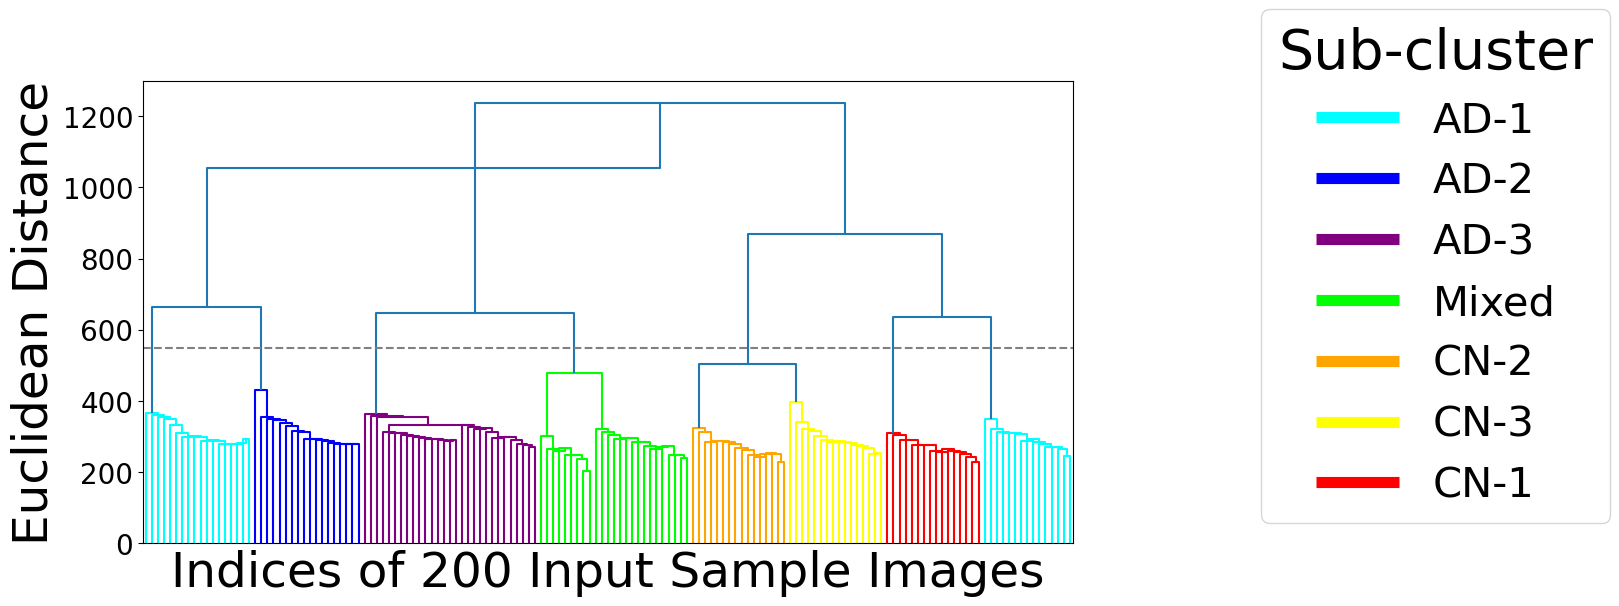

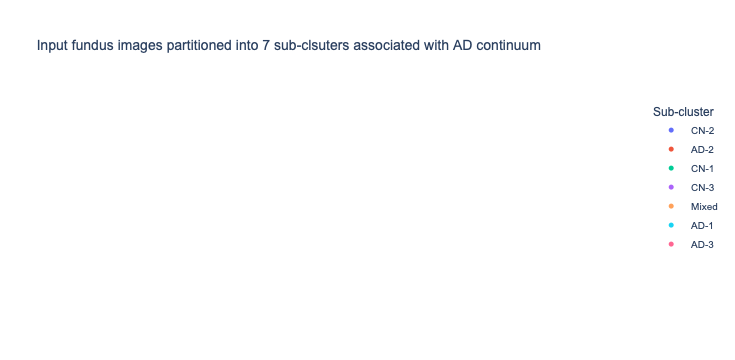

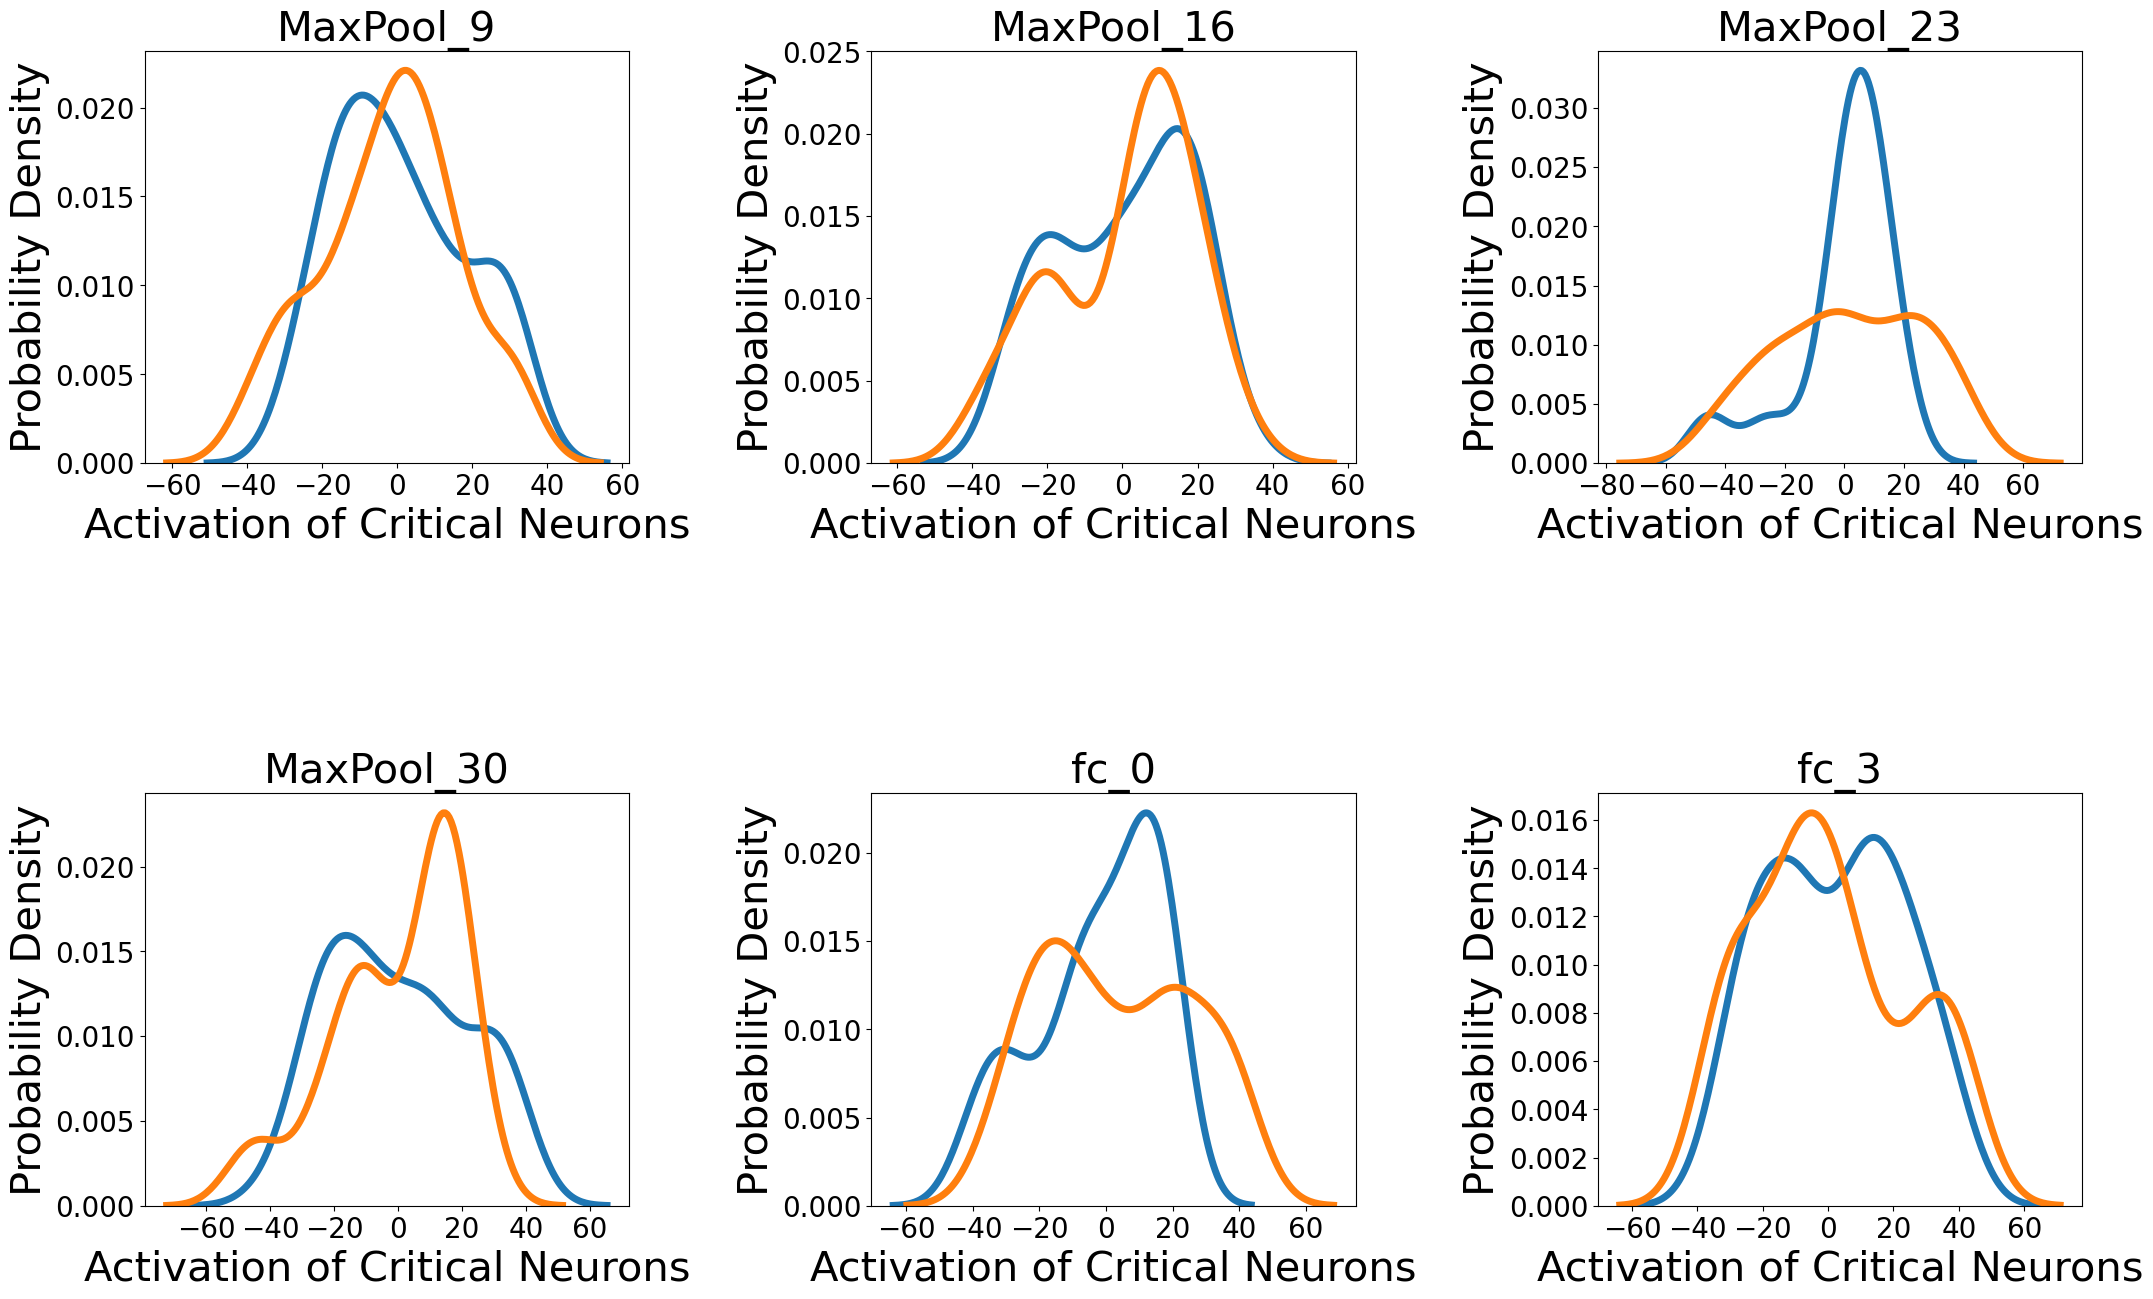